In [2]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt


In [3]:
# load data file (already in BERT unified data format)

# data_in = ert.load('data_unified/CER2017-08-24_u_i.txt') 
# data_in = ert.load('data_unified/craterlake_2019_feb6.txt') 
# data_in = ert.load('data_unified/fieldschool_wen3_2013_aug26.txt') # no permafrost. bad electrode to test filtering
# data_in = ert.load('data_unified/oldcrow_wen13_2013_oct14.txt') 
# data_in = ert.load('data_unified/oldcrow_wen1_2013_oct13.txt') 
data_in = ert.load('data_unified/SCH2018-08-29_u_i.txt') 
# data_in = ert.load('data_unified/Teller_ERTB_2019-10-03_0600.ohm') # data from the seward peninsula


print(data_in)

Data: Sensors: 50 data: 360, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'r', 'u', 'valid']


In [4]:
# calculate geometric factor and apparent resistivity if not already in data file

if max(data_in['k'])==0:
    data_in['k'] = ert.createGeometricFactors(data_in)
    
if max(data_in['rhoa'])==0: 
    if max(data_in['r'])==0: 
        data_in['rhoa'] = (data_in['u']/data_in['i'])*data_in['k'] 
    else:
        data_in['rhoa'] = data_in['r']*data_in['k']


21/07/21 - 14:03:07 - pyGIMLi - INFO - Cache C:\Users\limbrock\anaconda3\envs\idgsp\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 2): C:\Users\limbrock\AppData\Roaming\pygimli\Cache\9972367270546508547


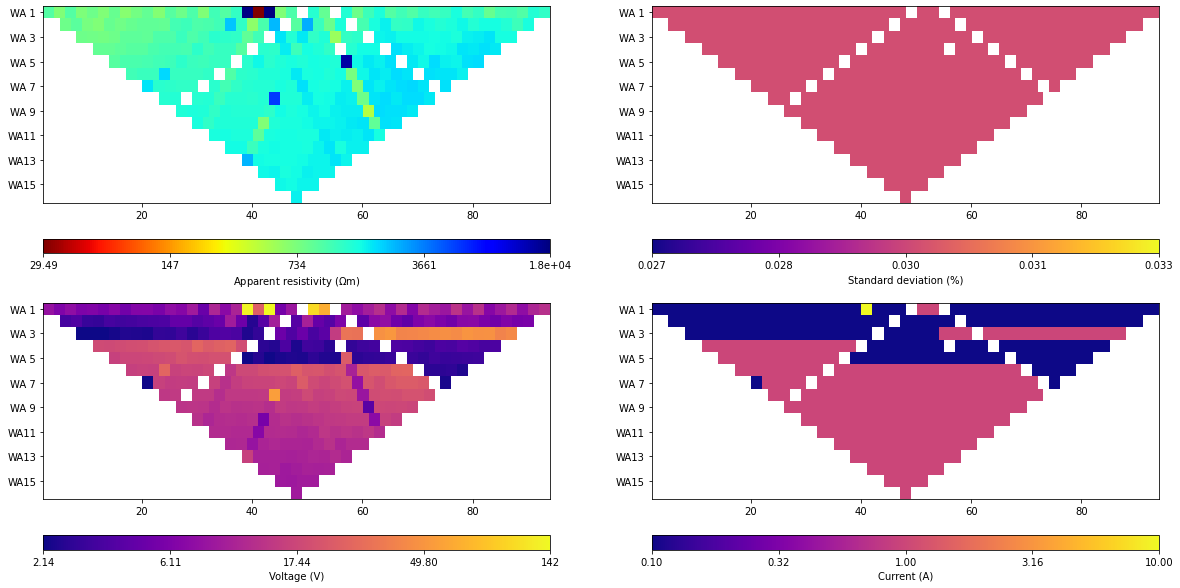

In [5]:
# plot raw data 

mgr = ert.ERTManager(data_in)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0,0],label=r'Apparent resistivity ($\Omega$m)',cMap='jet_r');

if max(data_in['err']>0):
    mgr.showData(data_in, vals=data_in['err'],ax=ax[0,1],label='Standard deviation (%)',cMap='plasma');
else:
    ax[0,1].text(0.35,0.5,'no err data available',fontsize=16)
    
if max(data_in['u']>0):    
    mgr.showData(data_in, vals=data_in['u'],ax=ax[1,0],label='Voltage (V)',cMap='plasma');
else:
    ax[1,0].text(0.35,0.5,'no voltage data available',fontsize=16)
    
if max(data_in['i']>0):
    mgr.showData(data_in, vals=data_in['i'],ax=ax[1,1],label='Current (A)',cMap='plasma');
else:
    ax[1,1].text(0.35,0.5,'no current data available',fontsize=16)

In [6]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 


# 1. put data into DataFrame (although there is probably a better way to do this)

df = pd.DataFrame(np.array(data_in.dataMap()).T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index()



# 2. find midpoint of array

mp = []
for i in range(len(data_in['a'])):
    mp.append(np.mean([
    data_in.sensors()[data_in['a']][i][0],
    data_in.sensors()[data_in['b']][i][0],
    data_in.sensors()[data_in['m']][i][0],
    data_in.sensors()[data_in['n']][i][0],
]))
    
mp = np.array(mp)


# 3. sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography

# to find unique depth levels, check to find unique relative positions of electrodes
ab = df['a'] - df['b']
am = df['a'] - df['m']
an = df['a'] - df['n']

a = (np.array([ab,am,an]).T).astype(dtype=float)

a_uniq = np.unique(a, axis=0)

# sort by depth level
sort_index = np.argsort(a)
i_all = np.linspace(0,len(a),len(a)+1).astype('int')
sort_index = np.array([])

# sort by midpoint
for i in range(len(a_uniq)):
    j = np.where((a==a_uniq[i]).all(axis=1))
    si = np.argsort(mp[j])
    sort_index = np.append(sort_index,i_all[j][si]) 

sort_index = sort_index.astype('int')
data_sort = pd.DataFrame(df,index=sort_index)


In [7]:
# this is the part where we filter the data

data_filt = data_sort.copy()



# step 1. technical filter

I = (np.unique(np.hstack([ 
    np.where(data_filt['rhoa'] < 0)[0],
    np.where(data_filt['err'] > 10)[0],
    np.where(data_filt['rhoa'] > 9*np.std(data_filt['rhoa']))[0]
])))

data_filt = data_filt.drop(I)
a = np.delete(a,I,0)
n_tf = len(I)



# step 2. moving median filter

th = 0.9 # threshold for filter
n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(data_filt.shape[0],dtype=bool)


for j in range(len(a_uniq)): # loop through each unique depth level
    
    I = np.unique(np.where(a==a_uniq[j])[0])
    
    # moving median of data points
    
    mm = [] 
    r = np.array(data_filt['rhoa'])[I]
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
        elif i==1:
            mm.append(np.median(r[i-1:4])) 
        elif i==len(r)-2:
            mm.append(np.median(r[i-2:])) 
        elif i==len(r)-1:
            mm.append(np.median(r[i-2:])) 
        else:
            mm.append(np.median(r[i-2:i+3])) 
    
    ithrow = np.where(abs(r-mm)/mm > th)[0]
    n_mmf = n_mmf + len(ithrow)
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)

data_filt = data_filt[ikeep]

data points removed by technical filter = 3
data points removed by moving median filter = 7


In [8]:
# put everything back into the data container

data_out = pg.DataContainerERT()

# sensors are the same
for i in range(0,len(data_in.sensors())):
    data_out.createSensor(np.array(data_in.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 
cols = data_filt.columns
for i in range(len(cols)):
    if max(data_filt[cols[i]]) > 0:
        data_out[cols[i]] = np.array(data_filt[cols[i]])

10 data points removed (2.8% of the data)


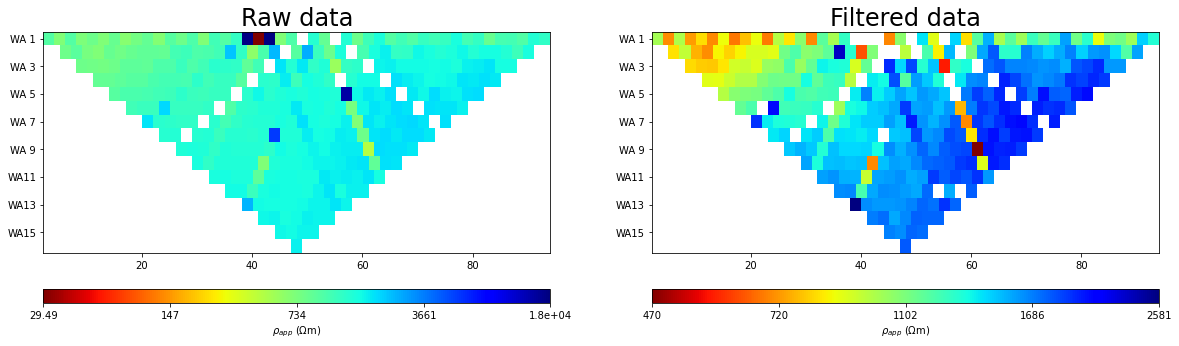

In [9]:
# plot filtered data

fig, ax = plt.subplots(1,2,figsize=[20,5])

d = data_in
mgr.showData(d, vals=d['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='jet_r');
ax[0].set_title('Raw data',fontsize=24);

d = data_out
mgr.showData(d, vals=d['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='jet_r');
ax[1].set_title('Filtered data',fontsize=24);

print('%.0f data points removed (%.1f%% of the data)'%(n_tf+n_mmf, float((data_in.size()-data_out.size())/data_in.size()*100)))

In [10]:
# first pass inversion

# assume simple noise model for now

data_out['err'] = ert.estimateError(
    data_out, 
    absoluteUError=0.00005, # 50µV
    relativeError=0.03 # 3% noise
)  

# set wether lambda is being optimized by L-curve
# reset to 'False'
mgr.inv.inv.setOptimizeLambda(False)


# run inversion

mod = mgr.invert(
    data_out,
    blockymodel=True, 
    robustdata=True,
    verbose=True, 
#     lam = 20, # can change regularization parameter
#     paraMaxCellSize=10, # can change the maximum cell area
#     zWeight=0.3 # can change the ratio of smoothness_z / smoothness_x
)

# getting lambda, used for the inversion
lam = mgr.inv.inv.getLambda()

21/07/21 - 14:03:12 - pyGIMLi - INFO - Found 2 regions.
21/07/21 - 14:03:12 - pyGIMLi - INFO - Region with smallest marker (1) set to background
21/07/21 - 14:03:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/07/21 - 14:03:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
21/07/21 - 14:03:12 - pyGIMLi - INFO - Starting inversion.
21/07/21 - 14:03:12 - pyGIMLi - INFO - Set default startmodel to median(data values)=1510.2917216400779
21/07/21 - 14:03:12 - pyGIMLi - INFO - Created startmodel from forward operator: 702 [1510.2917216400779,...,1510.2917216400779]


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000022E1B025680>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000022E1B025720>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000022E1ADB97C0>
min/max (data): 470/2581
min/max (error): 3.00%/3.00%
min/max (start model): 1510/1510
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 20.84 (dPhi = 9.79%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 19.19 (dPhi = 4.28%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 19.05 (dPhi = 0.85%) lam: 20.0
################################################################################
#                 Abort criteria reached: dPhi = 0.85 (< 2.0%)                 #
#########################

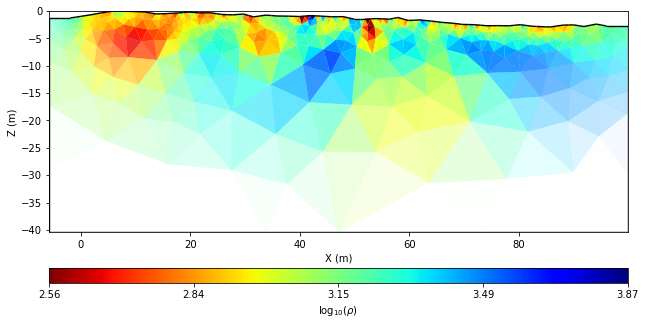

In [11]:
# plot results

fig, ax = plt.subplots(1,1,figsize=[20,5])

ax, cBar = mgr.showModel(
    np.log10(mod),
    ax=ax,
    cMap='jet_r',
    coverage=mgr.coverage()

);

cBar.set_label(r'log$_{10}$($\rho$)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)');


In [12]:
# run second inversion with optimized lambda:

# set wether lambda is being optimized by L-curve
mgr.inv.inv.setOptimizeLambda(True)

# run second inversion:
mod2 = mgr.invert(
    data_out,
    blockymodel=True, 
    robustdata=True,
    verbose=True, 
#    lam = 20, # can change regularization parameter#     paraMaxCellSize=10, # can change the maximum cell area
#     zWeight=0.3 # can change the ratio of smoothness_z / smoothness_x
)

# getting lambda, used for the inversion
lam2 = mgr.inv.inv.getLambda()

21/07/21 - 14:03:25 - pyGIMLi - INFO - Starting inversion.
21/07/21 - 14:03:25 - pyGIMLi - INFO - Set default startmodel to median(data values)=1510.2917216400779
21/07/21 - 14:03:25 - pyGIMLi - INFO - Created startmodel from forward operator: 702 [1510.2917216400779,...,1510.2917216400779]


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000022E1B025680>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000022E1B025720>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000022E1ADB97C0>
min/max (data): 470/2581
min/max (error): 3.00%/3.00%
min/max (start model): 1510/1510
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 20.57 (dPhi = 12.83%) lam: 12.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 18.31 (dPhi = 7.02%) lam: 12.8
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 18.12 (dPhi = 1.17%) lam: 12.8
################################################################################
#                 Abort criteria reached: dPhi = 1.17 (< 2.0%)                 #
########################

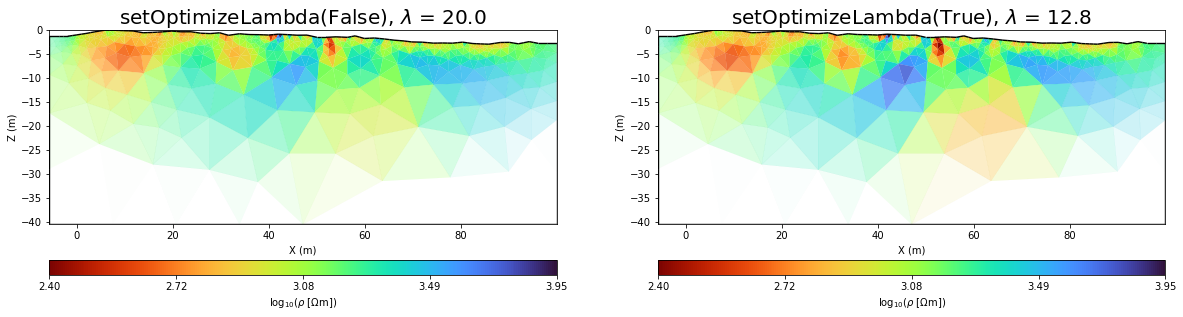

In [13]:
# plot results of both inversions
# Using same color scale for both plots: defining cMin and cMax
cMin = 2.4
cMax = 3.95

fig, ax = plt.subplots(1,2,figsize=[20,5])

mgr.showModel(
    np.log10(mod),ax=ax[0],
    label=r'log$_{10}$($\rho$ [$\Omega$m])',
    cMin=cMin, cMax=cMax,
    cMap='turbo_r',
    coverage=mgr.coverage()
)

ax[0].set_title('setOptimizeLambda(False), $\lambda$ = ' + str(lam),fontsize=20)
ax[0].set_xlabel('X (m)')
ax[0].set_ylabel('Z (m)');

mgr.showModel(
    np.log10(mod2),
    ax=ax[1],label=r'log$_{10}$($\rho$ [$\Omega$m])',
    cMin=cMin, cMax=cMax,
    cMap='turbo_r',
    coverage=mgr.coverage()
)

ax[1].set_title('setOptimizeLambda(True), $\lambda$ = ' + str(lam2),fontsize=20)
ax[1].set_xlabel('X (m)')
ax[1].set_ylabel('Z (m)');


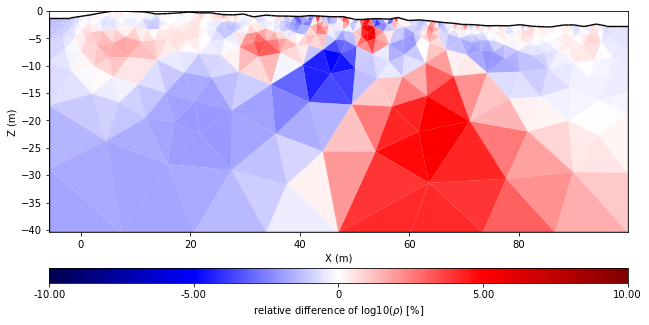

In [14]:
# plot the difference of both inversions
# caluclating the relative difference between both results
mod_mean =  (np.log10(mod) +  np.log10(mod2)) / 2
mod_dif =  (np.log10(mod) -  np.log10(mod2)) / mod_mean

# plot
fig, ax = plt.subplots(1,1,figsize=[20,5])
ax, cBar = mgr.showModel(
    mod_dif * 100,
    ax=ax,
    cMin=-10, cMax=10,
    cMap='seismic',
    logScale=False,
)

cBar.set_label(r'relative difference of log10($\rho$) [%]')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)');